# Lab 01: Siamese Network for Text Similarity

Use a subset of **Quora Question Pairs** - pairs of questions labeled as duplicate (1) or not duplicate (0).

In [1]:
# Install required packages
!pip install torch torchtext datasets scikit-learn matplotlib seaborn -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Preparation

In [3]:
# data for demonstration
synthetic_data = [
    # Similar pairs (label=1)
    ("How do I learn Python?", "What is the best way to learn Python?", 1),
    ("How can I lose weight?", "What are effective ways to lose weight?", 1),
    ("What is machine learning?", "Can you explain machine learning?", 1),
    ("How do I cook pasta?", "What is the recipe for cooking pasta?", 1),
    ("Where is Paris?", "What country is Paris in?", 1),
    ("How to train a neural network?", "What are the steps to train neural networks?", 1),
    ("What is PyTorch?", "Can you describe PyTorch framework?", 1),
    ("How to improve English?", "What are ways to get better at English?", 1),
    
    # Different pairs (label=0)
    ("How do I learn Python?", "What is the capital of France?", 0),
    ("How can I lose weight?", "What is machine learning?", 0),
    ("What is deep learning?", "How do I cook rice?", 0),
    ("Where is London?", "How to train for marathon?", 0),
    ("What is the weather today?", "How do I code in Java?", 0),
    ("Who invented electricity?", "What is the best pizza topping?", 0),
    ("How to play guitar?", "What is quantum physics?", 0),
    ("When was World War 2?", "How do I bake a cake?", 0),
]

# Expand dataset
expanded_data = synthetic_data * 50  # 800 samples
print(f"Total samples: {len(expanded_data)}")
print(f"\nFirst 3 samples:")
for q1, q2, label in expanded_data[:3]:
    print(f"Q1: {q1}")
    print(f"Q2: {q2}")
    print(f"Label: {'Similar' if label == 1 else 'Different'}\n")

Total samples: 800

First 3 samples:
Q1: How do I learn Python?
Q2: What is the best way to learn Python?
Label: Similar

Q1: How can I lose weight?
Q2: What are effective ways to lose weight?
Label: Similar

Q1: What is machine learning?
Q2: Can you explain machine learning?
Label: Similar



## 2. Vocabulary and Tokenization

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.freq_threshold = freq_threshold
    
    def build_vocabulary(self, sentences):
        word_freq = {}
        for sentence in sentences:
            for word in sentence.lower().split():
                word_freq[word] = word_freq.get(word, 0) + 1
        
        idx = len(self.word2idx)
        for word, freq in word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary size: {len(self.word2idx)}")
    
    def numericalize(self, text):
        return [self.word2idx.get(word.lower(), self.word2idx["<UNK>"]) 
                for word in text.split()]

# Build vocabulary
all_texts = [q1 for q1, q2, _ in expanded_data] + [q2 for q1, q2, _ in expanded_data]
vocab = Vocabulary(freq_threshold=1)
vocab.build_vocabulary(all_texts)

Vocabulary size: 76


## 3. Dataset Class

In [5]:
class SiameseDataset(Dataset):
    def __init__(self, data, vocab, max_len=20):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        q1, q2, label = self.data[idx]
        
        # Numericalize
        q1_indices = self.vocab.numericalize(q1)
        q2_indices = self.vocab.numericalize(q2)
        
        # Pad or truncate
        q1_indices = q1_indices[:self.max_len] + [0] * (self.max_len - len(q1_indices))
        q2_indices = q2_indices[:self.max_len] + [0] * (self.max_len - len(q2_indices))
        
        return (
            torch.tensor(q1_indices, dtype=torch.long),
            torch.tensor(q2_indices, dtype=torch.long),
            torch.tensor(label, dtype=torch.float)
        )

# Split data
train_data, test_data = train_test_split(expanded_data, test_size=0.2, random_state=42)
train_dataset = SiameseDataset(train_data, vocab)
test_dataset = SiameseDataset(test_data, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 640
Test samples: 160


## 4. Siamese Network Architecture

In [6]:
class TextEncoder(nn.Module):
    """Shared encoder for both inputs"""
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: [batch, seq_len]
        embedded = self.dropout(self.embedding(x))  # [batch, seq_len, embed_dim]
        output, (hidden, cell) = self.lstm(embedded)
        
        # Use mean pooling over sequence
        # output: [batch, seq_len, hidden*2]
        encoding = output.mean(dim=1)  # [batch, hidden*2]
        return encoding


class SiameseNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.encoder = TextEncoder(vocab_size, embed_dim, hidden_dim, dropout)
        
        # Projection layer to reduce dimensions
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 128)
        )
    
    def forward_once(self, x):
        """Forward pass through one branch"""
        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection
    
    def forward(self, q1, q2):
        # Process both inputs through shared encoder
        output1 = self.forward_once(q1)
        output2 = self.forward_once(q2)
        return output1, output2

# Initialize model
model = SiameseNetwork(
    vocab_size=len(vocab.word2idx),
    embed_dim=128,
    hidden_dim=256
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

SiameseNetwork(
  (encoder): TextEncoder(
    (embedding): Embedding(76, 128, padding_idx=0)
    (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (projection): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
)

Total parameters: 964,480


## 5. Loss Function: Contrastive Loss

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        # Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        # Contrastive loss
        loss = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss

criterion = ContrastiveLoss(margin=1.0)

## 6. Training Loop

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for q1, q2, labels in tqdm(dataloader, desc="Training"):
        q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output1, output2 = model(q1, q2)
        loss = criterion(output1, output2, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for q1, q2, labels in tqdm(dataloader, desc="Evaluating"):
            q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
            
            output1, output2 = model(q1, q2)
            loss = criterion(output1, output2, labels)
            total_loss += loss.item()
            
            # Calculate accuracy
            distances = F.pairwise_distance(output1, output2)
            predictions = (distances < threshold).float()
            correct += (predictions == (1 - labels)).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

In [9]:
# Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 55.69it/s]


Epoch 1/10
  Train Loss: 0.1759
  Test Loss: 0.0102 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 56.22it/s]


Epoch 2/10
  Train Loss: 0.0078
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 61.63it/s]


Epoch 3/10
  Train Loss: 0.0002
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 60.10it/s]


Epoch 4/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 60.78it/s]


Epoch 5/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 56.70it/s]


Epoch 6/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 61.33it/s]


Epoch 7/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 62.82it/s]


Epoch 8/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 63.13it/s]


Epoch 9/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 60.77it/s]

Epoch 10/10
  Train Loss: 0.0000
  Test Loss: 0.0000 | Test Acc: 1.0000



## 7. Visualization

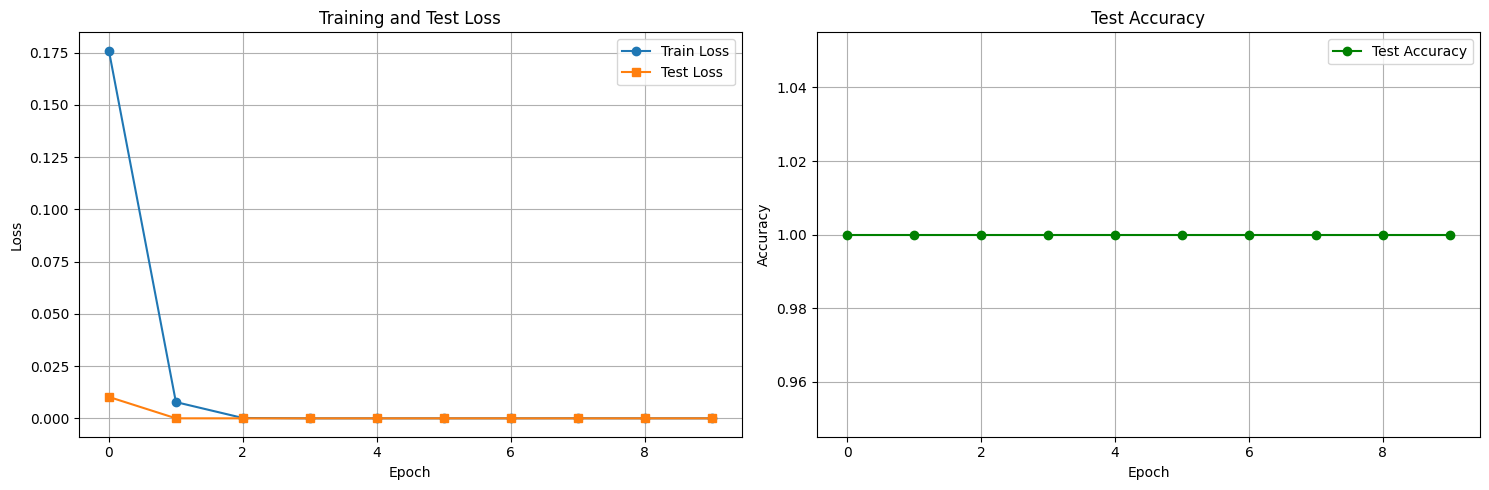

In [10]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(test_losses, label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(test_accuracies, label='Test Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Testing and Visualization

In [11]:
def predict_similarity(model, q1, q2, vocab, device, max_len=20):
    model.eval()
    
    # Preprocess
    q1_indices = vocab.numericalize(q1)
    q2_indices = vocab.numericalize(q2)
    
    q1_indices = q1_indices[:max_len] + [0] * (max_len - len(q1_indices))
    q2_indices = q2_indices[:max_len] + [0] * (max_len - len(q2_indices))
    
    q1_tensor = torch.tensor([q1_indices], dtype=torch.long).to(device)
    q2_tensor = torch.tensor([q2_indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output1, output2 = model(q1_tensor, q2_tensor)
        distance = F.pairwise_distance(output1, output2).item()
    
    return distance

# Test examples
test_pairs = [
    ("How do I learn Python?", "What is the best way to learn Python?"),
    ("How do I learn Python?", "What is the capital of France?"),
    ("What is machine learning?", "Can you explain machine learning?"),
    ("What is deep learning?", "How do I cook rice?"),
]

print("Similarity Predictions (lower distance = more similar)")

for q1, q2 in test_pairs:
    distance = predict_similarity(model, q1, q2, vocab, device)
    similarity = "SIMILAR" if distance < 0.5 else "DIFFERENT"
    
    print(f"Q1: {q1}")
    print(f"Q2: {q2}")
    print(f"Distance: {distance:.4f} → {similarity}\n")

Similarity Predictions (lower distance = more similar)
Q1: How do I learn Python?
Q2: What is the best way to learn Python?
Distance: 6.1756 → DIFFERENT

Q1: How do I learn Python?
Q2: What is the capital of France?
Distance: 0.0000 → SIMILAR

Q1: What is machine learning?
Q2: Can you explain machine learning?
Distance: 4.4848 → DIFFERENT

Q1: What is deep learning?
Q2: How do I cook rice?
Distance: 0.0000 → SIMILAR



## 9. Embedding Space Visualization

Applying t-SNE...


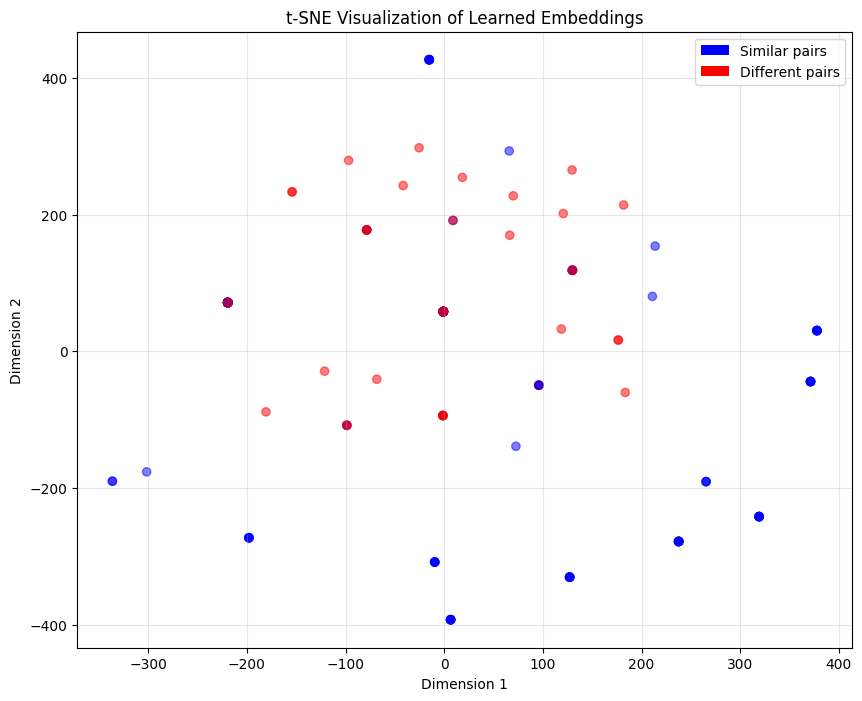

In [12]:
from sklearn.manifold import TSNE

# Get embeddings for test set
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for q1, q2, labels in test_loader:
        q1, q2 = q1.to(device), q2.to(device)
        output1, output2 = model(q1, q2)
        
        embeddings.append(output1.cpu().numpy())
        embeddings.append(output2.cpu().numpy())
        labels_list.extend(["similar" if l == 1 else "different" for l in labels])
        labels_list.extend(["similar" if l == 1 else "different" for l in labels])

embeddings = np.vstack(embeddings)

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings[:200])  # Use subset for speed

# Plot
plt.figure(figsize=(10, 8))
colors = ['red' if l == 'different' else 'blue' for l in labels_list[:200]]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.5)
plt.title('t-SNE Visualization of Learned Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Similar pairs'),
    Patch(facecolor='red', label='Different pairs')
]
plt.legend(handles=legend_elements)
plt.grid(True, alpha=0.3)
plt.show()

## 10. Save Model

In [13]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'config': {
        'vocab_size': len(vocab.word2idx),
        'embed_dim': 128,
        'hidden_dim': 256
    }
}, 'siamese_network.pt')

print("Saved to 'siamese_network.pt'")

Saved to 'siamese_network.pt'
